<a href="https://colab.research.google.com/github/prakash-bisht/Reinforcement-Learning/blob/main/Reinforcement_Learning_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os, shutil
from tqdm import tqdm

from rl_glue import RLGlue
from environment import BaseEnvironment
from agent import BaseAgent
from optimizer import BaseOptimizer
import plot_script
from randomwalk_environment import RandomWalkEnvironment

In [ ]:
def my_matmul(x1, x2):
    """
    Given matrices x1 and x2, return the multiplication of them
    """
    result = np.matmul(x1, x2)
    return result

In [ ]:
def get_value(s, weights):
    """
    Compute value of input s given the weights of a neural network
    """
    psi = my_matmul(s, weights[0]["W"]) + weights[0]["b"]
    x = np.maximum(0, psi)
    v = my_matmul(x, weights[1]["W"]) + weights[1]["b"]
    return v

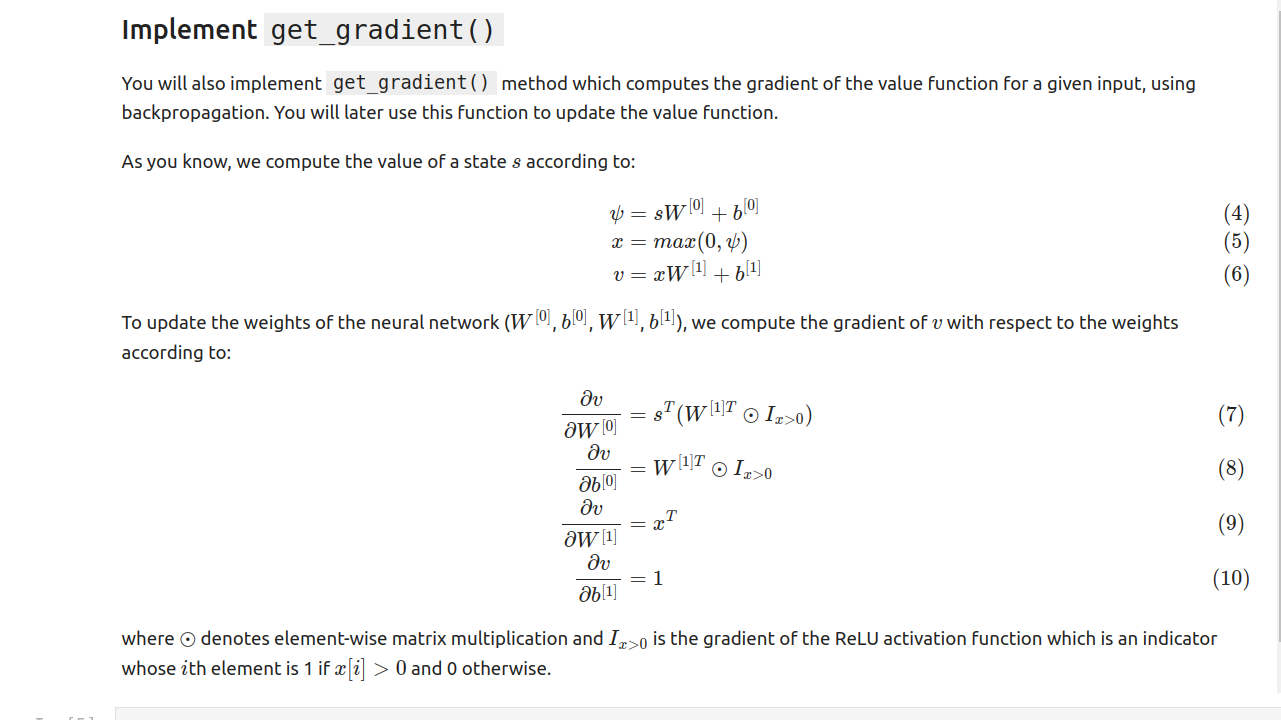

In [ ]:
def get_gradient(s, weights):
    """
    Given inputs s and weights, return the gradient of v with respect to the weights
    """

    grads = [dict() for i in range(len(weights))]
    psi = my_matmul(s, weights[0]["W"]) + weights[0]["b"]
    x = np.maximum(0, psi)
    I = (x > 0) * 1
    grads[0]["W"] = my_matmul(s.T, (weights[1]["W"].T * I))
    grads[0]["b"] = weights[1]["W"].T * I
    grads[1]["W"] = x.T
    grads[1]["b"] = 1

    return grads

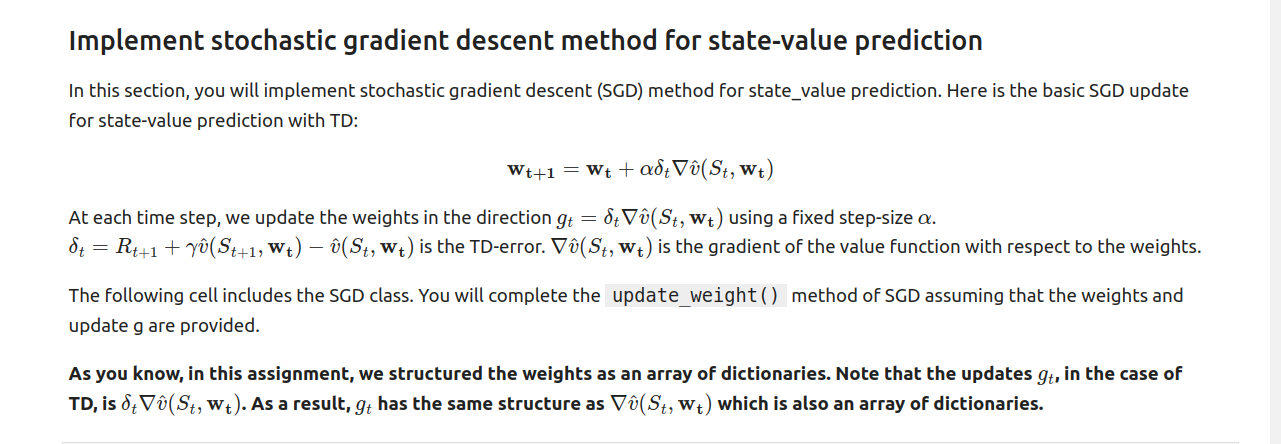

In [ ]:
class SGD(BaseOptimizer):
    def __init__(self):
        pass

    def optimizer_init(self, optimizer_info):
        """Setup for the optimizer.

        Set parameters needed to setup the stochastic gradient descent method.

        Assume optimizer_info dict contains:
        {
            step_size: float
        }
        """
        self.step_size = optimizer_info.get("step_size")

    def update_weights(self, weights, g):
        """
        Given weights and update g, return updated weights
        """
        for i in range(len(weights)):
            for param in weights[i].keys():
                weights[i][param] += self.step_size * g[i][param]

        return weights

In [ ]:
class Adam(BaseOptimizer):
    def __init__(self):
        pass

    def optimizer_init(self, optimizer_info):
        """Setup for the optimizer.

        Set parameters needed to setup the Adam algorithm.

        Assume optimizer_info dict contains:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float,
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
        }
        """

        self.num_states = optimizer_info.get("num_states")
        self.num_hidden_layer = optimizer_info.get("num_hidden_layer")
        self.num_hidden_units = optimizer_info.get("num_hidden_units")

        # Specify Adam algorithm's hyper parameters
        self.step_size = optimizer_info.get("step_size")
        self.beta_m = optimizer_info.get("beta_m")
        self.beta_v = optimizer_info.get("beta_v")
        self.epsilon = optimizer_info.get("epsilon")

        self.layer_size = np.array([self.num_states, self.num_hidden_units, 1])

        # Initialize Adam algorithm's m and v
        self.m = [dict() for i in range(self.num_hidden_layer+1)]
        self.v = [dict() for i in range(self.num_hidden_layer+1)]

        for i in range(self.num_hidden_layer+1):

            # Initialize self.m[i]["W"], self.m[i]["b"], self.v[i]["W"], self.v[i]["b"] to zero
            self.m[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.m[i]["b"] = np.zeros((1, self.layer_size[i+1]))
            self.v[i]["W"] = np.zeros((self.layer_size[i], self.layer_size[i+1]))
            self.v[i]["b"] = np.zeros((1, self.layer_size[i+1]))

        # Initialize beta_m_product and beta_v_product to be later used for computing m_hat and v_hat
        self.beta_m_product = self.beta_m
        self.beta_v_product = self.beta_v

    def update_weights(self, weights, g):
        """
        Given weights and update g, return updated weights
        """

        for i in range(len(weights)):
            for param in weights[i].keys():

                ### update self.m and self.v
                self.m[i][param] = self.beta_m * self.m[i][param] + (1 - self.beta_m) * g[i][param]
                self.v[i][param] = self.beta_v * self.v[i][param] + (1 - self.beta_v) * (g[i][param] * g[i][param])

                ### compute m_hat and v_hat
                m_hat = self.m[i][param] / (1 - self.beta_m_product)
                v_hat = self.v[i][param] / (1 - self.beta_v_product)

                ### update weights
                weights[i][param] += self.step_size * m_hat / (np.sqrt(v_hat) + self.epsilon)

        self.beta_m_product *= self.beta_m
        self.beta_v_product *= self.beta_v

        return weights

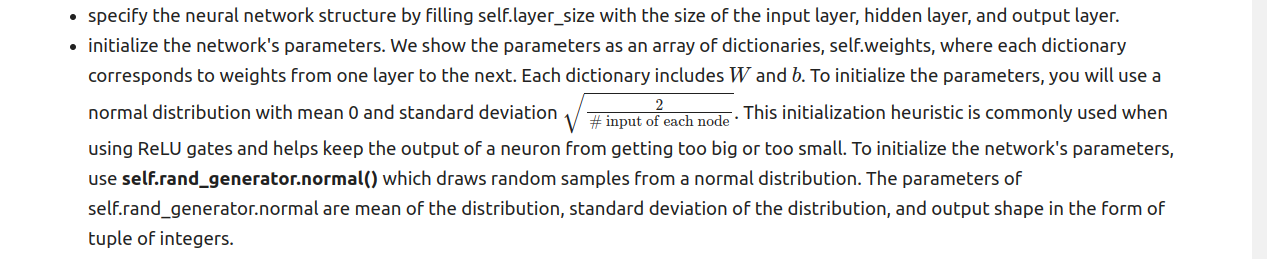

In [ ]:
def one_hot(state, num_states):
    """
    Given num_state and a state, return the one-hot encoding of the state
    """
    one_hot_vector = np.zeros((1,num_states))
    one_hot_vector[0,int(state-1)] = 1
    return one_hot_vector

In [ ]:
class TDAgent(BaseAgent):
    def __init__(self):
        self.name = "td_agent"
        pass

    def agent_init(self, agent_info={}):
        """Setup for the agent called when the experiment first starts.

        Set parameters needed to setup the semi-gradient TD with a Neural Network.

        Assume agent_info dict contains:
        {
            num_states: integer,
            num_hidden_layer: integer,
            num_hidden_units: integer,
            step_size: float,
            discount_factor: float,
            self.beta_m: float
            self.beta_v: float
            self.epsilon: float
            seed: int
        }
        """

        # Set random seed for weights initialization for each run
        self.rand_generator = np.random.RandomState(agent_info.get("seed"))

        # Set random seed for policy for each run
        self.policy_rand_generator = np.random.RandomState(agent_info.get("seed"))

        # Set attributes according to agent_info
        self.num_states = agent_info.get("num_states")
        self.num_hidden_layer = agent_info.get("num_hidden_layer")
        self.num_hidden_units = agent_info.get("num_hidden_units")
        self.discount_factor = agent_info.get("discount_factor")

        self.layer_size = np.array([self.num_states,self.num_hidden_units,self.num_hidden_layer])
        self.weights = [dict() for  i in range(self.num_hidden_layer+1)]

        for i in range(self.num_hidden_layer+1):
          input_size,output_size = self.layer_size[i],self.layer_size[i+1]
          self.weights[i]["W"] = self.rand_generator.normal(0,np.sqrt(2/input_size),(input_size,output_size))
          self.weights[i]['b'] = self.rand_generator.normal(0,np.sqrt(2/input_size),(1,output_size))

        self.optimizer = Adam()
        optimizer_info = {"num_states": agent_info["num_states"],
                          "num_hidden_layer": agent_info["num_hidden_layer"],
                          "num_hidden_units": agent_info["num_hidden_units"],
                          "step_size": agent_info["step_size"],
                          "beta_m": agent_info["beta_m"],
                          "beta_v": agent_info["beta_v"],
                          "epsilon": agent_info["epsilon"]}
        self.optimizer.optimizer_init(optimizer_info)

        self.last_state = None
        self.last_action = None

    def agent_policy(self,state):
      action = self.policy_rand_generator.choice([0,1])
      return action

    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state from the
                environment's evn_start function.
        Returns:
            The first action the agent takes.
        """
        action = self.agent_policy(state)
        self.last_action = action
        self.last_state = state
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        last_state_vector = one_hot(self.last_state,self.num_states)
        last_value = get_value(last_state_vector,self.weights)

        current_state_vector = one_hot(state,self.num_states)
        current_value = get_value(current_state_vector,self.weights)

        delta = reward + self.discount_factor * current_value - last_value

        grads = get_gradient(last_state_vector, self.weights)

        g = [dict() for i in range(self.num_hidden_layer +1)]
        for i in range(self.num_hidden_layer + 1):
          for params in self.weights[i].keys():
            g[i][params] = delta * grads[i][params]

        self.weights = self.optimizer.update_weights(self.weights, g)

        action = self.agent_policy(state)
        self.last_state = state
        self.last_action = action

        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        last_state_vector = one_hot(self.last_state, self.num_states)
        last_value = get_value(last_state_vector, self.weights)

        delta = reward - last_value
        grads = get_gradient(last_state_vector, self.weights)
        g = [dict() for i in range(self.num_hidden_layer+1)]
        for i in range(self.num_hidden_layer+1):
            for param in self.weights[i].keys():
                g[i][param] = delta * grads[i][param]

        self.weights = self.optimizer.update_weights(self.weights, g)

    def agent_message(self, message):
        if message == 'get state value':
            state_value = np.zeros(self.num_states)
            for state in range(1, self.num_states + 1):
                s = one_hot(state, self.num_states)
                state_value[state - 1] = get_value(s, self.weights)
            return state_value


Setting - Neural Network with 100 hidden units


  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-11-a6b471756a6b>:132: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  state_value[state - 1] = get_value(s, self.weights)
100%|██████████| 20/20 [21:08<00:00, 63.45s/it]


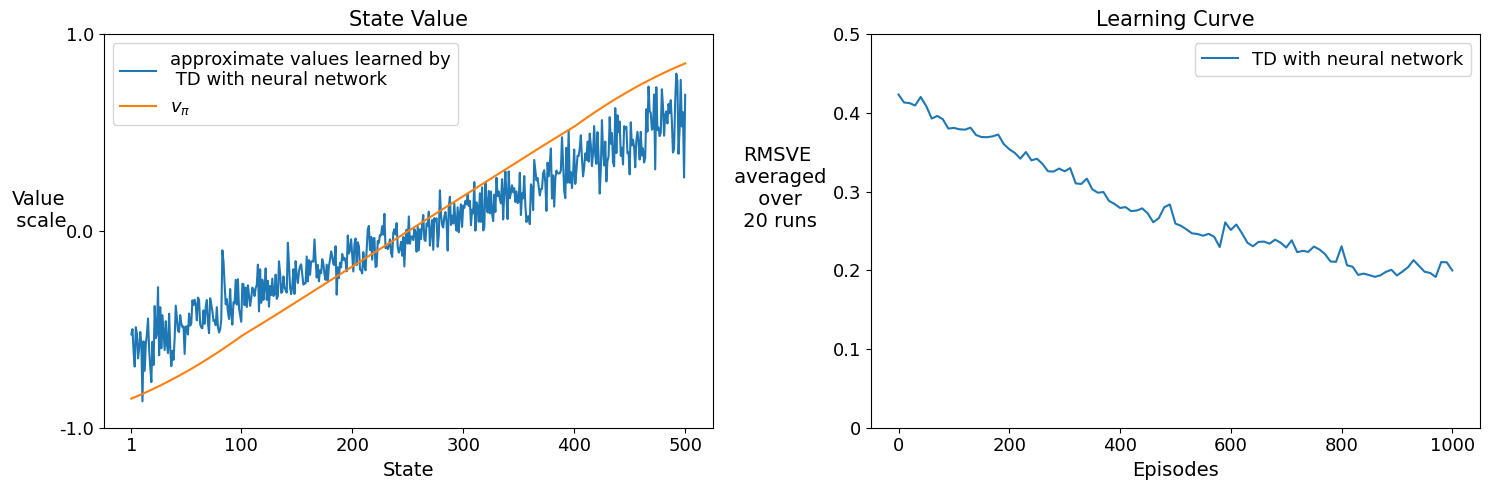

'/content/Reinforcement-Learning-Specialization/Prediction and Control with Function Approximation/Week 2/Notebook: Semi-gradient TD with a Neural Network/results.zip'

In [ ]:
true_state_val = np.load('data/true_V.npy')
state_distribution = np.load('data/state_distribution.npy')

def calc_RMSVE(learned_state_val):
    assert(len(true_state_val) == len(learned_state_val) == len(state_distribution))
    MSVE = np.sum(np.multiply(state_distribution, np.square(true_state_val - learned_state_val)))
    RMSVE = np.sqrt(MSVE)
    return RMSVE

# Define function to run experiment
def run_experiment(environment, agent, environment_parameters, agent_parameters, experiment_parameters):

    rl_glue = RLGlue(environment, agent)

    # save rmsve at the end of each episode
    agent_rmsve = np.zeros((experiment_parameters["num_runs"],
                            int(experiment_parameters["num_episodes"]/experiment_parameters["episode_eval_frequency"]) + 1))

    # save learned state value at the end of each run
    agent_state_val = np.zeros((experiment_parameters["num_runs"],
                                environment_parameters["num_states"]))

    env_info = {"num_states": environment_parameters["num_states"],
                "start_state": environment_parameters["start_state"],
                "left_terminal_state": environment_parameters["left_terminal_state"],
                "right_terminal_state": environment_parameters["right_terminal_state"]}

    agent_info = {"num_states": environment_parameters["num_states"],
                  "num_hidden_layer": agent_parameters["num_hidden_layer"],
                  "num_hidden_units": agent_parameters["num_hidden_units"],
                  "step_size": agent_parameters["step_size"],
                  "discount_factor": environment_parameters["discount_factor"],
                  "beta_m": agent_parameters["beta_m"],
                  "beta_v": agent_parameters["beta_v"],
                  "epsilon": agent_parameters["epsilon"]
                 }

    print('Setting - Neural Network with 100 hidden units')
    os.system('sleep 1')

    # one agent setting
    for run in tqdm(range(1, experiment_parameters["num_runs"]+1)):
        env_info["seed"] = run
        agent_info["seed"] = run
        rl_glue.rl_init(agent_info, env_info)

        # Compute initial RMSVE before training
        current_V = rl_glue.rl_agent_message("get state value")
        agent_rmsve[run-1, 0] = calc_RMSVE(current_V)

        for episode in range(1, experiment_parameters["num_episodes"]+1):
            # run episode
            rl_glue.rl_episode(0) # no step limit

            if episode % experiment_parameters["episode_eval_frequency"] == 0:
                current_V = rl_glue.rl_agent_message("get state value")
                agent_rmsve[run-1, int(episode/experiment_parameters["episode_eval_frequency"])] = calc_RMSVE(current_V)
            elif episode == experiment_parameters["num_episodes"]: # if last episode
                current_V = rl_glue.rl_agent_message("get state value")

        agent_state_val[run-1, :] = current_V

    save_name = "{}".format(rl_glue.agent.name).replace('.','')

    if not os.path.exists('results'):
                os.makedirs('results')

    # save avg. state value
    np.save("results/V_{}".format(save_name), agent_state_val)

    # save avg. rmsve
    np.savez("results/RMSVE_{}".format(save_name), rmsve = agent_rmsve,
                                                   eval_freq = experiment_parameters["episode_eval_frequency"],
                                                   num_episodes = experiment_parameters["num_episodes"])


# Run Experiment

# Experiment parameters
experiment_parameters = {
    "num_runs" : 20,
    "num_episodes" : 1000,
    "episode_eval_frequency" : 10 # evaluate every 10 episode
}

# Environment parameters
environment_parameters = {
    "num_states" : 500,
    "start_state" : 250,
    "left_terminal_state" : 0,
    "right_terminal_state" : 501,
    "discount_factor" : 1.0
}

# Agent parameters
agent_parameters = {
    "num_hidden_layer": 1,
    "num_hidden_units": 100,
    "step_size": 0.001,
    "beta_m": 0.9,
    "beta_v": 0.999,
    "epsilon": 0.0001,
}

current_env = RandomWalkEnvironment
current_agent = TDAgent

# run experiment
run_experiment(current_env, current_agent, environment_parameters, agent_parameters, experiment_parameters)

# plot result
plot_script.plot_result(["td_agent"])

shutil.make_archive('results', 'zip', 'results')

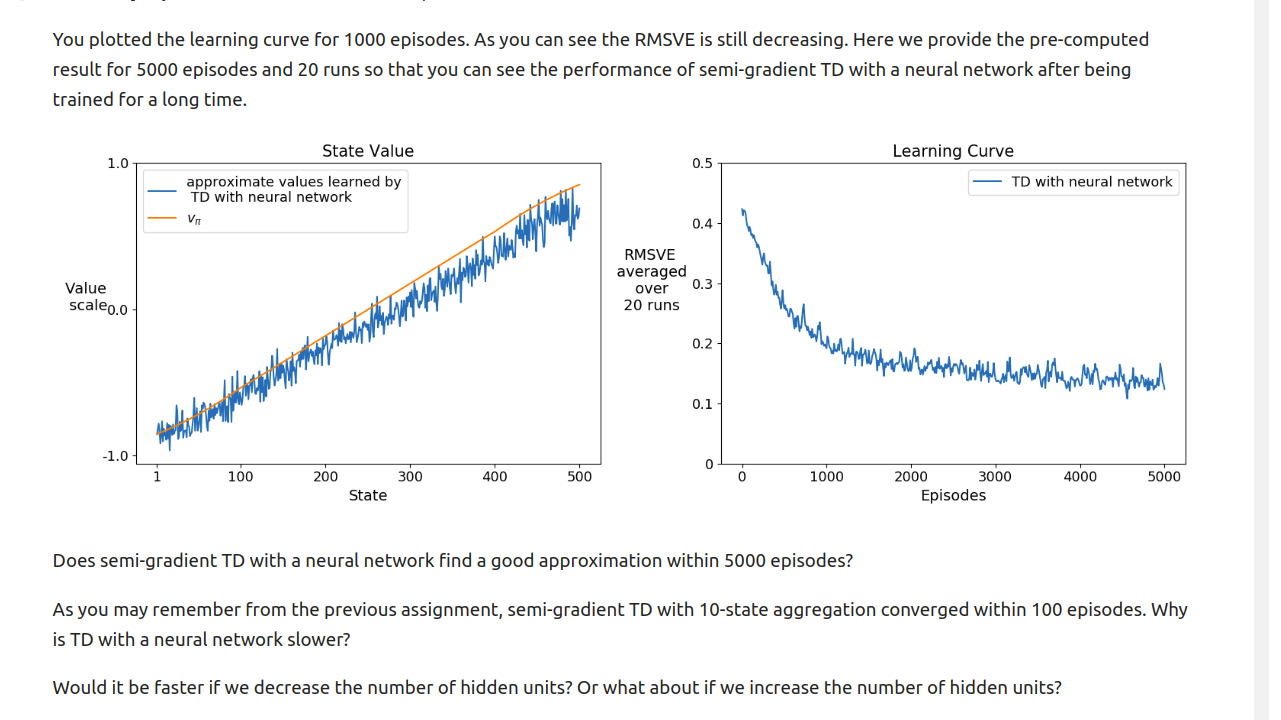

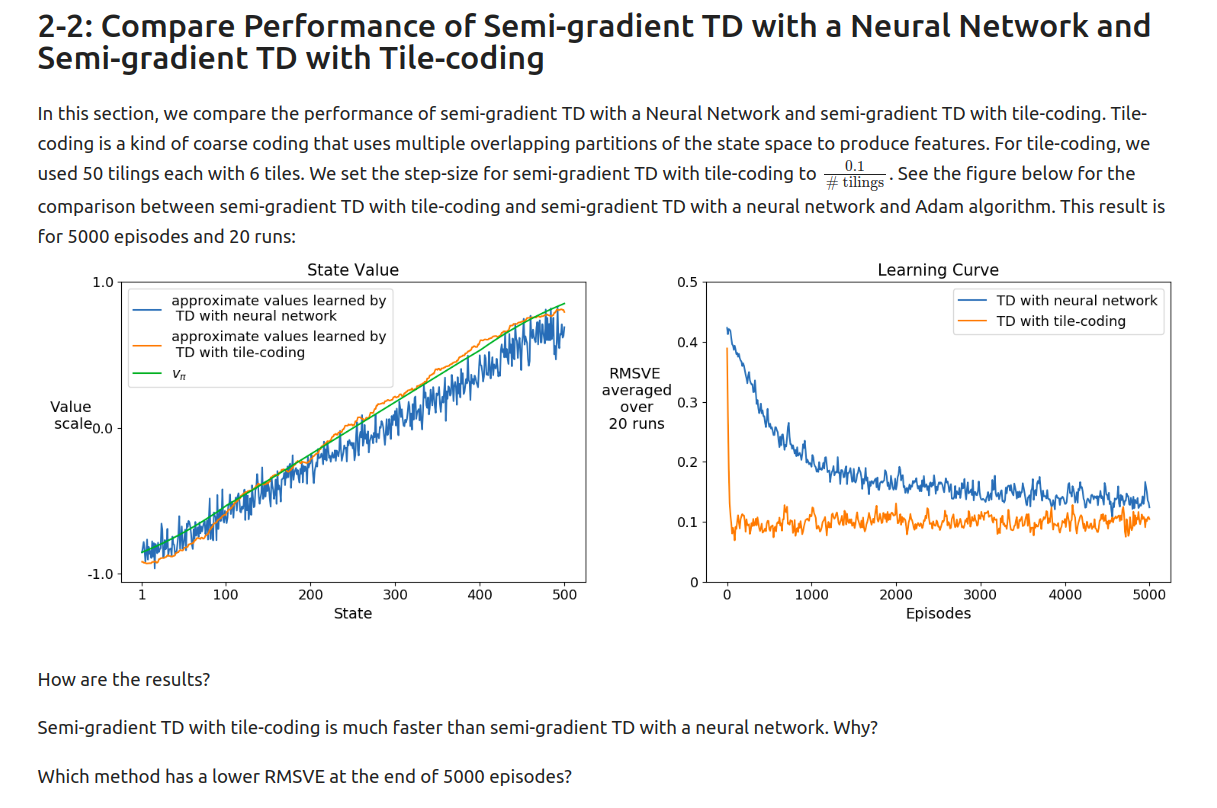